In [5]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import  DataLoader
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import matplotlib.lines as lines
torch.manual_seed(100)
np.random.seed(0)
from pytorch_forecasting import TimeSeriesDataSet

In [6]:
X = pd.read_csv("../data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
y = pd.read_csv("../data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("../data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
train_names=X.columns

#print (X)
GW=X.iloc[:,:23]
SW=X.iloc[:,23:]
#print(SW)
dates=X.index
print(dates[770])


Initial Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St. Marks River @ San Marcos de Apalachee S.P.
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded Input Shape:  (1101, 64)
2019-03-08 00:00:00


In [3]:
#Min Max gets output between 0 and 1
#Stadard Scaler gets standard distribution scaling
mm=MinMaxScaler()
ss=StandardScaler()
X_ss=ss.fit_transform(X)
y_mm=mm.fit_transform(y)
print()

#Splitting to a 70 Train:30 Test
print('Combined Shapes')
X_train=X_ss[:770,:]
X_test=X_ss[770:,:]
y_train=y_mm[:770,:]
y_test=y_mm[770:,:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('Only GW shapes')
GW_X_train=X_ss[:770,:23]
GW_X_test=X_ss[770:,:23]
GW_X_ss=X_ss[:,:23]


print(GW_X_train.shape)

print(GW_X_test.shape)

print('Only SW shapes')
SW_X_train=X_ss[:770,23:]
SW_X_test=X_ss[770:,23:]
SW_X_ss=X_ss[:,23:]

print(SW_X_train.shape)

print(SW_X_test.shape)

Combined Shapes
(770, 64)
(770, 1)
(331, 64)
(331, 1)
Only GW shapes
(770, 23)
(331, 23)
Only SW shapes
(770, 41)
(331, 41)


In [30]:
###TEST DATASET
class


SyntaxError: invalid syntax (<ipython-input-30-befdbe9f393d>, line 2)

In [4]:
#Combined tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

#GW Tensors
GW_X_train_tensors = Variable(torch.Tensor(GW_X_train))
GW_X_test_tensors = Variable(torch.Tensor(GW_X_test))

#SW Tensors
SW_X_train_tensors = Variable(torch.Tensor(SW_X_train))
SW_X_test_tensors = Variable(torch.Tensor(SW_X_test))

#Spring Tensors
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [5]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

GW_X_train_tensors_final = torch.reshape(GW_X_train_tensors,   (GW_X_train_tensors.shape[0], 1, GW_X_train_tensors.shape[1]))
GW_X_test_tensors_final = torch.reshape(GW_X_test_tensors,  (GW_X_test_tensors.shape[0], 1, GW_X_test_tensors.shape[1]))

SW_X_train_tensors_final = torch.reshape(SW_X_train_tensors,   (SW_X_train_tensors.shape[0], 1, SW_X_train_tensors.shape[1]))
SW_X_test_tensors_final = torch.reshape(SW_X_test_tensors,  (SW_X_test_tensors.shape[0], 1, SW_X_test_tensors.shape[1]))

print("Both Training Shape. Input: ", X_train_tensors_final.shape, " Target: ",y_train_tensors.shape)
print("Both Testing Shape. Input", X_test_tensors_final.shape, " Target: ",y_test_tensors.shape) 

Both Training Shape. Input:  torch.Size([770, 1, 64])  Target:  torch.Size([770, 1])
Both Testing Shape. Input torch.Size([331, 1, 64])  Target:  torch.Size([331, 1])


In [6]:
#Long Short-Term Memory
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.dropout=nn.Dropout(0.5)

        self.fc_1 =  nn.Linear(hidden_size, hidden_size) #fully connected 1
        
        self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        
        #x1 = Variable(torch.Tensor(x))
        #x2 = torch.reshape(x1,   (x1.shape[0], 1, x.shape[1]))

    
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.dropout(out)
        out = self.fc_1(out) #first Dense
        #out = self.relu(out) #relu
        out = self.dropout(out)
        out = self.fc(out) #Final Output
        return out

In [7]:
#Hyper Parameters #BOTH
num_epochs = 500 #1000 epochs
learning_rate = 0.001 #0.001 lr
BATCH_SIZE=14
input_size = 64 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [8]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

print(lstm1)

LSTM1(
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_1): Linear(in_features=64, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [9]:
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=lstm1.forward(X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 

Epoch: 0, loss: 0.21460
Epoch: 100, loss: 0.01120
Epoch: 200, loss: 0.00810
Epoch: 300, loss: 0.00695
Epoch: 400, loss: 0.00554


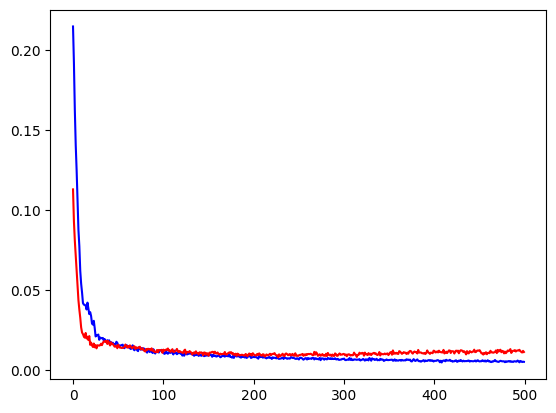

227


In [10]:
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)

print(index)

In [11]:
new_num_epochs=index+2

lstm2 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate) 

train_loss_list = []
test_loss_list = []

for epoch in range(new_num_epochs):
    
    outputs = lstm2.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=lstm1.forward(X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 

Epoch: 0, loss: 0.05635
Epoch: 10, loss: 0.02277
Epoch: 20, loss: 0.01249
Epoch: 30, loss: 0.01077
Epoch: 40, loss: 0.00933
Epoch: 50, loss: 0.00820
Epoch: 60, loss: 0.00788
Epoch: 70, loss: 0.00681
Epoch: 80, loss: 0.00630
Epoch: 90, loss: 0.00606
Epoch: 100, loss: 0.00605
Epoch: 110, loss: 0.00576
Epoch: 120, loss: 0.00503
Epoch: 130, loss: 0.00492
Epoch: 140, loss: 0.00459
Epoch: 150, loss: 0.00501
Epoch: 160, loss: 0.00472
Epoch: 170, loss: 0.00484
Epoch: 180, loss: 0.00426
Epoch: 190, loss: 0.00465
Epoch: 200, loss: 0.00422
Epoch: 210, loss: 0.00442
Epoch: 220, loss: 0.00407


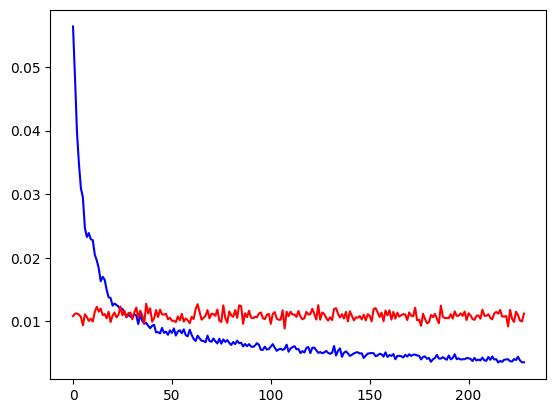

107


In [12]:
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)

print(index)

In [19]:
df_X_ss = Variable(torch.Tensor(X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

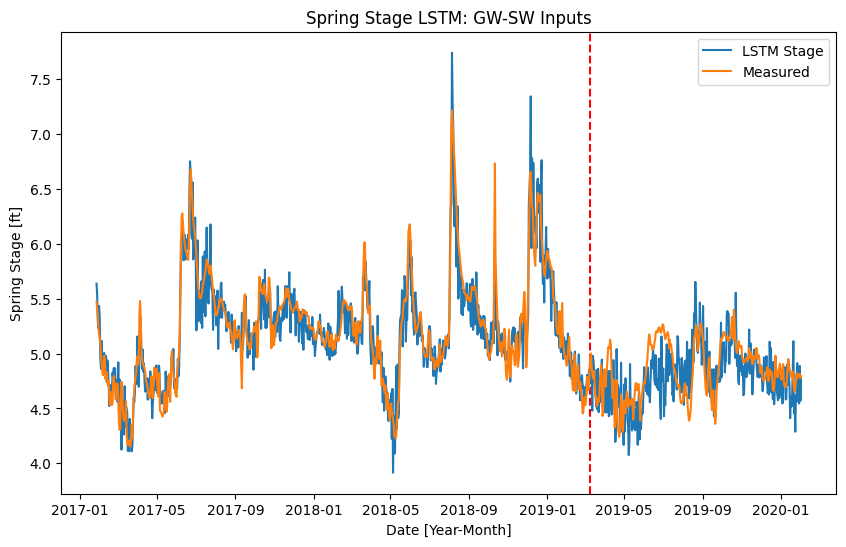

In [14]:
train_predict = lstm2(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=dates[770], c='r', linestyle='--') #size of the training set

plt.plot(dates, data_predict, label='LSTM Stage') #predicted plot

plt.plot(dates, dataY_plot, label='Measured') #actual plot
plt.title('Spring Stage LSTM: GW-SW Inputs')
plt.ylabel("Spring Stage [ft]")
plt.xlabel("Date [Year-Month]")
plt.legend()

#plt.savefig('../plots/LSTM_GWSW.SVG')
plt.show()
plt.close()


In [15]:
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

In [16]:
######Performance Method of Test set
#reshaping the dataset
df_X_ss = Variable(torch.Tensor(X_test)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_test))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm2(X_test_tensors_final)#forward pass
predict_scaled = train_predict.data.numpy() #numpy conversion

predictTest = mm.inverse_transform(predict_scaled)
actualTest = mm.inverse_transform(y_test)

test_rmse=mse(actualTest, predictTest)**0.5
#mae_score= mae(actualTest, predictTest)
test_r_sq=r2(actualTest, predictTest)

full_rmse=mse(dataY_plot, data_predict)**0.5
full_r_sq=r2(dataY_plot, data_predict)
full_nse=nse(data_predict,dataY_plot)
print("Test RMSE:" , test_rmse, "\nTest R2: ", test_r_sq, "\nFull RMSE:" , full_rmse, "\nfull R2: ", full_r_sq,
     "\nNSE: ", full_nse)

Test RMSE: 0.24972298497695156 
Test R2:  -0.06869277269809437 
Full RMSE: 0.20817793573875143 
full R2:  0.7996097166370143 
NSE:  0.7996097058057785


In [20]:
nse(data_predict,dataY_plot)

0.8029463291168213

LSTM1(
  (lstm): LSTM(23, 23, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_1): Linear(in_features=23, out_features=23, bias=True)
  (fc): Linear(in_features=23, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch: 0, loss: 0.07629
Epoch: 100, loss: 0.01447
Epoch: 200, loss: 0.01065


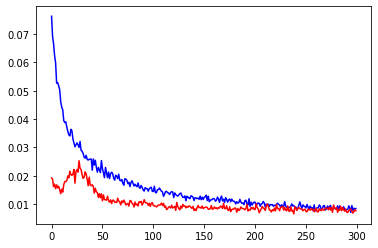

238


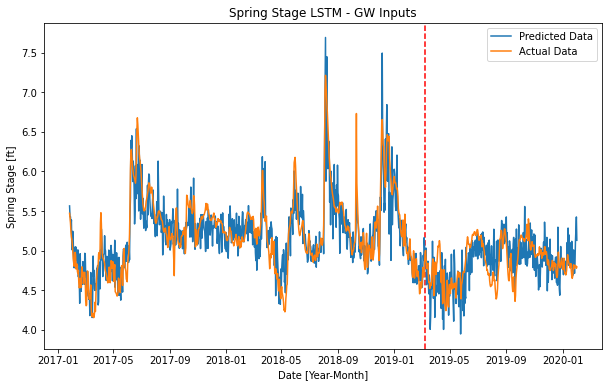

Test RMSE: 0.32856516779243594 
Test R2:  -0.8500304589606806 
Full RMSE: 0.25739407541211706 
full R2:  0.6936595234562561 
NSE:  0.6936595439910889


In [21]:
### GW ONLY LSTM
#Hyper Parameters #GW
num_epochs = 300 #1000 epochs
learning_rate = 0.001 #0.001 lr
BATCH_SIZE=14
input_size = 23 #number of features
hidden_size = 23 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 


# DEFINE NET
GW_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, GW_X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(GW_lstm.parameters(), lr=learning_rate) 

print(GW_lstm)

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    
    outputs = GW_lstm.forward(GW_X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=GW_lstm.forward(GW_X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 
        
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)
print(index)

df_X_ss = Variable(torch.Tensor(GW_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

train_predict = GW_lstm(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=dates[770], c='r', linestyle='--') #size of the training set

plt.plot(dates, data_predict, label='Predicted Data') #predicted plot

plt.plot(dates, dataY_plot, label='Actual Data') #actual plot
plt.title('Spring Stage LSTM - GW Inputs')
plt.ylabel("Spring Stage [ft]")
plt.xlabel("Date [Year-Month]")
plt.legend()

#plt.savefig('./plots/LSTM_GW.PNG')

plt.show()
plt.close()

######Performance Method of Test set
#reshaping the dataset
df_X_ss = Variable(torch.Tensor(X_test)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_test))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(X_test_tensors_final)#forward pass
predict_scaled = train_predict.data.numpy() #numpy conversion

predictTest = mm.inverse_transform(predict_scaled)
actualTest = mm.inverse_transform(y_test)

test_rmse=mse(actualTest, predictTest)**0.5
#mae_score= mae(actualTest, predictTest)
test_r_sq=r2(actualTest, predictTest)

full_rmse=mse(dataY_plot, data_predict)**0.5
full_r_sq=r2(dataY_plot, data_predict)
full_nse=nse(data_predict,dataY_plot)
print("Test RMSE:" , test_rmse, "\nTest R2: ", test_r_sq, "\nFull RMSE:" , full_rmse, "\nfull R2: ", full_r_sq,
     "\nNSE: ", full_nse)

LSTM1(
  (lstm): LSTM(41, 41, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_1): Linear(in_features=41, out_features=41, bias=True)
  (fc): Linear(in_features=41, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch: 0, loss: 0.28129
Epoch: 100, loss: 0.01983
Epoch: 200, loss: 0.01319


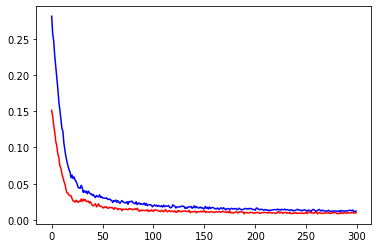

261


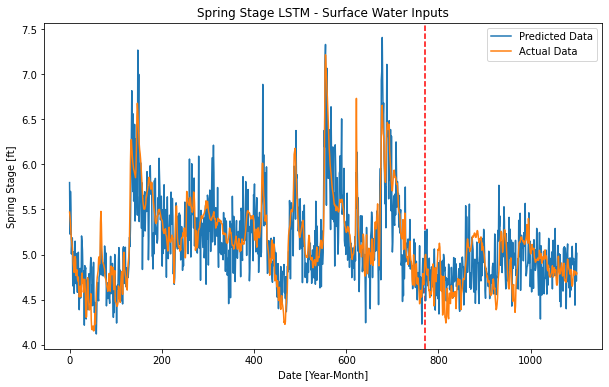

Test RMSE: 0.30250322703563287 
Test R2:  -0.5681798217438083 
Full RMSE: 0.3174540982519455 
full R2:  0.5340179702477821 
NSE:  0.5340179800987244


In [22]:
### SW ONLY LSTM
#Hyper Parameters #SW
num_epochs = 300 #1000 epochs
learning_rate = 0.001 #0.001 lr
BATCH_SIZE=14
input_size = 41 #number of features
hidden_size = 41 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 


# DEFINE NET
SW_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, SW_X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(SW_lstm.parameters(), lr=learning_rate) 

print(SW_lstm)

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    
    outputs = SW_lstm.forward(SW_X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=SW_lstm.forward(SW_X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 
        
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)
print(index)

df_X_ss = Variable(torch.Tensor(SW_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

train_predict = SW_lstm(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=770, c='r', linestyle='--') #size of the training set

plt.plot(data_predict, label='Predicted Data') #predicted plot

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.title('Spring Stage LSTM - Surface Water Inputs')
plt.ylabel("Spring Stage [ft]")
plt.xlabel("Date [Year-Month]")
plt.legend()
plt.show()


######Performance Method of Test set
#reshaping the dataset
df_X_ss = Variable(torch.Tensor(SW_X_test)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_test))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = SW_lstm(SW_X_test_tensors_final)#forward pass
predict_scaled = train_predict.data.numpy() #numpy conversion

predictTest = mm.inverse_transform(predict_scaled)
actualTest = mm.inverse_transform(y_test)

test_rmse=mse(actualTest, predictTest)**0.5
#mae_score= mae(actualTest, predictTest)
test_r_sq=r2(actualTest, predictTest)

full_rmse=mse(dataY_plot, data_predict)**0.5
full_r_sq=r2(dataY_plot, data_predict)
full_nse=nse(data_predict,dataY_plot)
print("Test RMSE:" , test_rmse, "\nTest R2: ", test_r_sq, "\nFull RMSE:" , full_rmse, "\nfull R2: ", full_r_sq,
     "\nNSE: ", full_nse)

# XAI 

In [17]:
import shap

In [20]:
Xtrain_shap=df_X_ss[0:770]
#torch.nn.modules.module.register_full_backward_hook()

explainer = shap.DeepExplainer(lstm2, Xtrain_shap)

shap_values=explainer.shap_values(df_X_ss[770:])
shap_values.shape

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(331, 1, 64)

In [22]:
new_sv=shap_values.reshape(331,64)
new_sv.shape

(331, 64)

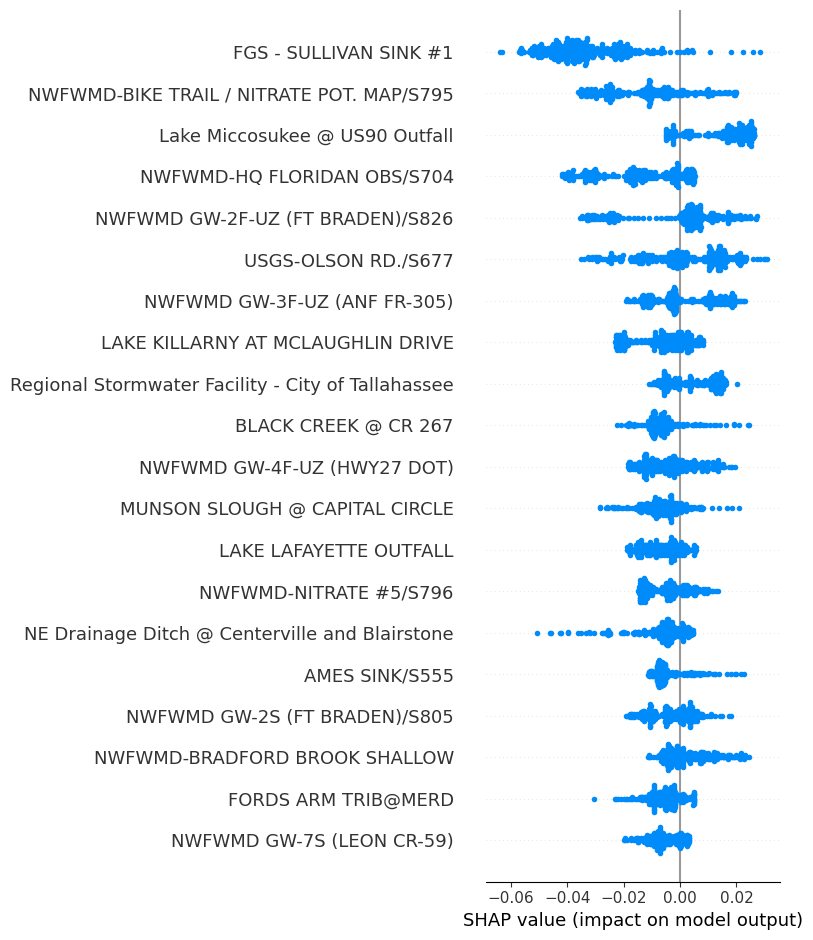

In [24]:
shap.initjs()
#shap.force_plot(explainer.expected_value[0], new_sv[50],train_names)

fig = shap.summary_plot(new_sv, feature_names=train_names,  show=False)
#fig = shap.summary_plot(new_sv, feature_names=train_names, plot_type='violin', max_display=20, show=False)
#plt.close()
#plt.savefig('../plots/SHAP_summary_top20.SVG', bbox_inches = "tight")

In [ ]:
#explainer = shap.KernelExplainer(model = lstm2, data = X_train, link = "identity")
#print(train_names)

In [ ]:
shap.plots.bar(new_sv[

# To Do

A) Nowcasting
1. Add 30 day sequence window as input for nowcast
2. Add Monitoring of accuracy along trraining and Test (Find ideal Training time)
3. Test with and without dropout layer to LSTM (Follow LSTM Ye Paper)
4. SHAP values. Comapre with known conduits

b) Forecasting
1. Experiment with different forecast lengths 
2. See how accuracy changes over forecast length
3. See hhow SHAP changes over time.|
